In [2]:
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv("drugsComTrain_raw.csv")

In [22]:
#check the distribution of medical conditions in the dataset
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [23]:
df.shape

(161297, 7)

In [24]:
#To make it simple we will select the top 4 medical conditions i.e., Birth Control, Depression, Diabetes, Type 2, and High Blood Pressure

df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]

In [25]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54
14,98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3,7-Aug-14,10


In [26]:
#After selecting the top 3 medical conditions, we will remove other features from the dataset
#As for building a classifier, we need textual review and the medical condition as the target variable

X = df_train.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)

In [27]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42732 entries, 2 to 161291
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   condition  42732 non-null  object
 1   review     42732 non-null  object
dtypes: object(2)
memory usage: 1001.5+ KB


In [29]:
X['condition'].unique()

array(['Birth Control', 'Depression', 'Diabetes, Type 2',
       'High Blood Pressure'], dtype=object)

In [30]:
#first we will remove double quotes from the dataset

for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [31]:
X.head()

,condition,review
2,Birth Control,"I used to take another oral contraceptive, whi..."
3,Birth Control,This is my first time using any form of birth ...
9,Birth Control,I had been on the pill for many years. When my...
11,Depression,"I have taken anti-depressants for years, with ..."
14,Birth Control,Started Nexplanon 2 months ago because I have ...


In [32]:
#we will create a review cleaning function that will remove HTML tags, lowercase the text reviews, retain only alphabets,
#remove stop words, and perform lemmatization

from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

X['review_clean'] = X['review'].apply(review_to_words)

#creating feature and target variable
X_feat=X['review_clean']
y=X['condition']

X.head()

C:\Users\srich\AppData\Local\Temp\ipykernel_19304\3945194392.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


,condition,review,review_clean
2,Birth Control,"I used to take another oral contraceptive, whi...",used take another oral contraceptive pill cycl...
3,Birth Control,This is my first time using any form of birth ...,first time using form birth control glad went ...
9,Birth Control,I had been on the pill for many years. When my...,pill many year doctor changed rx chateal effec...
11,Depression,"I have taken anti-depressants for years, with ...",taken anti depressant year improvement mostly ...
14,Birth Control,Started Nexplanon 2 months ago because I have ...,started nexplanon month ago minimal amount con...


*As we can see from the above output reviews are not cleaned properly which we can use for vectorizing using TF-IDF*

`TF-IDF` :- Term Frequency - Inverse Document Frequency 

In [33]:
#we will proceed to Train Test split
#we are using 80% of the data for training the model and rest 20% for testing the model

X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [1]:
X_test

NameError: name 'X_test' is not defined

In [34]:
#vectorize the data using TF-IDF and use Bi-grams for the same

tfidf_vectorizer2 = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

In [49]:
#saving TfidfVectorizer to use in Django backend
joblib.dump(tfidf_vectorizer2, 'tfidf_vectorizer2.pkl')

['tfidf_vectorizer2.pkl']

In TfidfVectorizer we have used two parameters one is max_df =0.8 means the bigrams which come less than or equal to 80% of the time in the document will be considered for vectorization. The second one is ngram_range=(1,2) it means we want to consider both unigram and bi-grams for vectorizing the data.

In [35]:
tfidf_train_2

<34185x402984 sparse matrix of type '<class 'numpy.float64'>'
	with 2744286 stored elements in Compressed Sparse Row format>

In [36]:
'''from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

# Define the base models
clf1 = LogisticRegression(random_state=42, max_iter=1000)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GradientBoostingClassifier(random_state=42)

# Create the ensemble model
ensemble_clf = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('gb', clf3)
], voting='hard')

# Train the ensemble model
ensemble_clf.fit(tfidf_train_2, y_train)

# Predict on the test data
y_pred = ensemble_clf.predict(tfidf_test_2)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.2f}")

# saving the trained model
joblib.dump(ensemble_clf, 'condition_predictor.pkl')'''

'from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import accuracy_score\nimport joblib\n\n# Define the base models\nclf1 = LogisticRegression(random_state=42, max_iter=1000)\nclf2 = RandomForestClassifier(random_state=42)\nclf3 = GradientBoostingClassifier(random_state=42)\n\n# Create the ensemble model\nensemble_clf = VotingClassifier(estimators=[\n    (\'lr\', clf1),\n    (\'rf\', clf2),\n    (\'gb\', clf3)\n], voting=\'hard\')\n\n# Train the ensemble model\nensemble_clf.fit(tfidf_train_2, y_train)\n\n# Predict on the test data\ny_pred = ensemble_clf.predict(tfidf_test_2)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nprint(f"Ensemble Model Accuracy: {accuracy:.2f}")\n\n# saving the trained model\njoblib.dump(ensemble_clf, \'condition_predictor.pkl\')'

In [37]:
shape_train = np.shape(tfidf_train_2)
shape_test = np.shape(tfidf_test_2)

print(f"Shape of tfidf_train_2: {shape_train}")
print(f"Shape of tfidf_test_2: {shape_test}")

Shape of tfidf_train_2: (34185, 402984)
Shape of tfidf_test_2: (8547, 402984)


In [38]:
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix

# Example: Convert tfidf_train_2 to COO format
tfidf_train_coo = tfidf_train_2.tocoo()

# Extract row, column, and data arrays
rows = tfidf_train_coo.row
cols = tfidf_train_coo.col
data = tfidf_train_coo.data

# Combine row and column indices
indices = np.vstack((rows, cols)).T

# Sort indices lexicographically (row-first, then column)
sorted_indices = np.lexsort((cols, rows))

# Apply sorted order to indices and data
sorted_rows = rows[sorted_indices]
sorted_cols = cols[sorted_indices]
sorted_data = data[sorted_indices]

# Recreate the sparse matrix with sorted indices
sorted_tfidf_train = coo_matrix((sorted_data, (sorted_rows, sorted_cols)), shape=tfidf_train_coo.shape).tocsr()

# Verify if sorted
print(sorted_tfidf_train)

# Example: Convert tfidf_train_2 to COO format
tfidf_test_coo = tfidf_test_2.tocoo()

# Extract row, column, and data arrays
rows = tfidf_test_coo.row
cols = tfidf_test_coo.col
data = tfidf_test_coo.data

# Combine row and column indices
indices = np.vstack((rows, cols)).T

# Sort indices lexicographically (row-first, then column)
sorted_indices = np.lexsort((cols, rows))

# Apply sorted order to indices and data
sorted_rows = rows[sorted_indices]
sorted_cols = cols[sorted_indices]
sorted_data = data[sorted_indices]

# Recreate the sparse matrix with sorted indices
sorted_tfidf_test = coo_matrix((sorted_data, (sorted_rows, sorted_cols)), shape=tfidf_test_coo.shape).tocsr()

# Verify if sorted
print()
print()
print('sorted_tfidf_test')
print(sorted_tfidf_test)

  (0, 339)	0.06854012060236003
  (0, 548)	0.12183765867771082
  (0, 32882)	0.0732079285602754
  (0, 32968)	0.11765206068328983
  (0, 44228)	0.11412252217965402
  (0, 44276)	0.17251891535784497
  (0, 125306)	0.04074735439292641
  (0, 126083)	0.13015251558806154
  (0, 130442)	0.03524114744319962
  (0, 130868)	0.11688133935417756
  (0, 139312)	0.12611801151837707
  (0, 140712)	0.03724136728191053
  (0, 141708)	0.12851853580733077
  (0, 159661)	0.05635531838126448
  (0, 160227)	0.17251891535784497
  (0, 166153)	0.06068150218614246
  (0, 166612)	0.10733414278895508
  (0, 168832)	0.07572394695166668
  (0, 168958)	0.16600973623921125
  (0, 178000)	0.08135905253596183
  (0, 178088)	0.140172446068342
  (0, 187048)	0.11614593088275453
  (0, 187083)	0.17251891535784497
  (0, 213091)	0.1056288926980593
  (0, 213127)	0.17251891535784497
  :	:
  (34184, 277198)	0.04506900987546514
  (34184, 277273)	0.12703438694284
  (34184, 286223)	0.0601746814006478
  (34184, 286485)	0.12271237701797687
  (34184, 

In [39]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [42]:
'''import tensorflow as tf
import numpy as np

# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(sorted_tfidf_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(np.max(y_train_encoded) + 1, activation='softmax')  # Output layer for classification
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3,
                                                  restore_best_weights=True)


# Train the model
history = model.fit(sorted_tfidf_train,
                    y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data=(sorted_tfidf_test, y_test_encoded),
                    callbacks=[early_stopping])'''

"import tensorflow as tf\nimport numpy as np\n\n# Define and compile the model\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Dense(128, activation='relu', input_shape=(sorted_tfidf_train.shape[1],)),\n    tf.keras.layers.Dense(64, activation='relu'),\n    tf.keras.layers.Dense(np.max(y_train_encoded) + 1, activation='softmax')  # Output layer for classification\n])\n\nmodel.compile(optimizer='adam',\n              loss='sparse_categorical_crossentropy',\n              metrics=['accuracy'])\n\n# Define early stopping\nearly_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                                  patience=3,\n                                                  restore_best_weights=True)\n\n\n# Train the model\nhistory = model.fit(sorted_tfidf_train,\n                    y_train_encoded,\n                    epochs=10,\n                    batch_size=32,\n                    validation_data=(sorted_tfidf_test, y_test_encoded),\n               

268/268 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5758
           1       0.98      0.97      0.98      1814
           2       0.95      0.96      0.95       511
           3       0.93      0.93      0.93       464

    accuracy                           0.99      8547
   macro avg       0.96      0.97      0.96      8547
weighted avg       0.99      0.99      0.99      8547



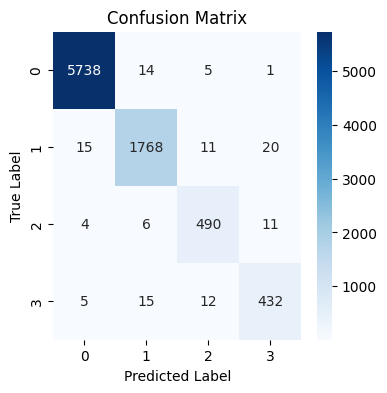

In [46]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
y_pred_proba = model.predict(sorted_tfidf_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Print classification report
print(classification_report(y_test_encoded, y_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Saving the model
#model.save('condition_predictor_dnn.h5')

In [51]:
## Function for Extracting Top drugs
import joblib

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer2.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

# sample input sentences for recommending drugs
def get_sentences():
    sentences = []
    print("Enter your sentences one by one. Press Enter on an empty line to stop.")

    while True:
        sentence = input("Enter a sentence: ")
        print()
        if sentence.strip() == "":
            print()
            break
        sentences.append(sentence)

    return sentences

sentences = get_sentences()

tfidf_trigram = tfidf_vectorizer2.transform(sentences)

condition_predictor = joblib.load('condition_predictor.pkl')


predictions = condition_predictor.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label=="High Blood Pressure":
        target="High Blood Pressure"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Diabetes, Type 2":
        target="Diabetes, Type 2"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    else:
        target="Birth Control"
        print("text:", text, "\Condition:", target)
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()

Enter your sentences one by one. Press Enter on an empty line to stop.


Enter a sentence:  oo


Enter a sentence:  




text: oo \Condition: Birth Control
text: oo 
Condition: Birth Control
Top 3 Suggested Drugs:
Mirena
Levonorgestrel
Implanon



In [53]:
df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])

joblib.dump(df_top, 'df_top.pkl')

['df_top.pkl']